## Tutorial5 : Clustering & Anomaly Detection Using `scikit-learn` and `scipy`

In this tutorial you will explore the concepts of clustering and anomaly detection using Python's `scikit-learn` and `scipy` libraries.

In [2]:
# some imports are provided here for you
# you may add additional imports if needed
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import random as rand
import itertools as it
import scipy.cluster.hierarchy

from pandas import DataFrame, Series

from numpy.testing import (TestCase, run_module_suite, dec, assert_raises,
                           assert_allclose, assert_equal, assert_, assert_warns)

from scipy.cluster import hierarchy as hier
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cophenet

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.model_selection import StratifiedKFold

In [3]:
%matplotlib inline

### Data

For this assigment you'll be working with the Epileptic Seizure Recognition Data Set developed at Rochester Institute of Technology. In this data set each row is a sample of the EEG recording at a different point in time. The dataset contains 179 columns, the first 178 are the EEG features while the last column represents the label y {1, 2, 3, 4, 5}. All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure. The class labels will not be used for clustering (which is an *unsupervised* task!) - they will just be used for plotting the data. The only change that was made to the original dataset was removing the first column, which contained the row indexes. You can find additional information about the dataset [here](https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition).

In [4]:
# Reading the Epileptic Seizure Data Set
dataset = pd.read_csv("seizure_edited.csv", header = 0)
print(dataset.shape)

#split the dataset into features and labels
labels = dataset['y']
data = dataset.drop('y', axis = 1)

dataset.head(10)

(11500, 179)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
5,55,28,18,16,16,19,25,40,52,66,...,-12,-31,-42,-54,-60,-64,-60,-56,-55,5
6,-55,-9,52,111,135,129,103,72,37,0,...,-125,-99,-79,-62,-41,-26,11,67,128,4
7,1,-2,-8,-11,-12,-17,-15,-16,-18,-17,...,-79,-91,-97,-88,-76,-72,-66,-57,-39,2
8,-278,-246,-215,-191,-177,-167,-157,-139,-118,-92,...,-400,-379,-336,-281,-226,-174,-125,-79,-40,1
9,8,15,13,3,-6,-8,-5,4,25,41,...,49,31,11,-5,-17,-19,-15,-15,-11,4


### Part 1: Data scaling & dimensionality reduction with PCA

Both K-means and DBSCAN break down in high dimensions, as distance (and thus density) become less meaningful in high dimensions. So, before we run either of these clustering algorithms, we want to reduce the dimensionality of our dataset. Recall that it is critical to scale your data prior to running PCA. 

Q1. 
* Use `sklearn.preprocessing.StandardScaler` to standardize the dataset’s features (mean = 0 and variance = 1). Only standardize the the features, not the class labels! This will be required for running the principal component analysis (PCA) dimensionality reduction. Note that `StandardScaler` returns a numpy array.
* Use `sklearn.decomposition.PCA` to perform PCA on the data.
* Set `n_components` to 0.95 and `svd_solver` to 'full', so that the PCA will reduce the number of dimensions to however many are necessary to retail 95% of the variance. 
* Use `fit_transform` to perform the dimensionality reduction. 
* Note that `fit_transform` returns a numpy array. Put your transformed data back into a Pandas DataFrame by doing something like this (subsitute your variable names): `data = DataFrame(pca_data)`
* Show the head of the resulting DataFrame (and make sure the dimenaionality has actually been reduced).

In [5]:
# create standard scaler object
scaler = StandardScaler()
# standardize the data
scaled_feature_data = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

# perform PCA 
pca = PCA(n_components=0.95, svd_solver='full')
pca.fit_transform(scaled_feature_data)
pca_data = pca.fit_transform(scaled_feature_data)
pca_data = DataFrame(pca_data)
pca_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,-0.137475,-1.146419,0.836893,-0.071085,-0.177048,-0.825731,0.777044,0.337638,2.744494,-0.734679,...,0.994987,-2.154933,1.053161,-0.090869,0.254414,-0.225816,-1.055100,-0.320229,0.195361,-0.102763
1,-1.703794,-3.643195,6.153822,8.033432,4.549536,5.892971,3.758370,-5.804916,4.187441,11.192247,...,-5.864539,-7.613729,5.082526,-2.786232,1.832683,2.158849,2.594621,-0.218890,0.437192,-3.813345
2,0.495650,-0.261660,0.931210,-0.663789,1.587618,-1.604942,-0.880830,-1.591959,-0.400873,-1.435073,...,0.124686,0.027333,0.946955,0.827331,-0.611872,0.389295,-0.490630,0.015729,-0.180175,0.048221
3,-0.174219,0.249557,-0.073646,-0.108047,1.615415,-3.136337,-0.559638,-3.032901,-0.222729,-1.465921,...,-0.322617,0.162047,-0.002372,-0.053858,-0.205829,-0.160254,0.048781,0.088260,0.201175,0.139328
4,-0.239163,0.117304,0.486502,-0.530629,0.187739,-0.371186,-0.045861,0.481596,-0.094907,0.541482,...,-0.360548,-0.399276,0.100645,-0.334393,0.155918,-0.114335,0.262911,-0.916693,0.658297,-0.122812
5,0.341840,0.083319,-0.404271,0.684176,-0.733687,1.507446,0.680056,0.848290,0.247059,-0.246276,...,-0.123540,-0.333288,0.765853,0.445032,0.552340,-0.035500,0.032115,0.092435,-0.416938,-0.369268
6,0.430794,0.172050,0.138366,-0.539700,0.098236,0.841051,0.260163,1.469505,0.694535,0.005560,...,0.181529,1.090898,-1.093767,-0.915146,-0.627678,-0.476141,-0.253018,-0.342835,0.010451,-0.140312
7,-0.241768,0.194411,-0.592769,-0.499100,0.284564,-1.777381,0.555976,-1.443498,1.097548,0.960977,...,0.051767,0.022412,0.243084,-0.222817,-0.000785,-0.005456,0.206362,-0.053709,-0.005960,-0.171605
8,2.693092,-2.715778,0.883136,4.299721,1.958305,-2.150193,-4.819647,0.450756,0.440971,-0.774489,...,-0.526299,1.272543,-0.739935,-0.956253,1.020405,-0.863924,-0.463710,-0.674500,-0.882790,-0.298188
9,-0.058517,-0.174253,-0.126161,-0.004984,-0.451385,0.858773,0.486604,0.666725,0.120098,-0.860483,...,0.040987,0.064881,0.171789,0.140052,0.022782,0.541749,0.095203,0.423380,0.027932,0.242532


Q2. We have provided code here to plot the data. This code uses `sklearn.manifold.MDS` to project the data onto 2 dimensions. It first randomly samples 300 rows from the entire dataset, then runs MDS on this sample, and plots it on a scatter plot. The points will be marked with appropriate colors based on their labels. 
* Pass your dataset (that has been reduced in dimensions from Q1) and the labels into this scatter function. Verify that the plot looks like 2 clusters: an inner cluster (non-seizure patients, labels 2-5), and an outer cluster (seizure patients, label 1).

In [6]:
# do not change this plotting function!
def scatter(data, labels, numPoints = 300):
    
    numEntries = data.shape[0]
    start = rand.randint(0, numEntries - numPoints)
    end = start + numPoints
    data = data.iloc[start:end, :]
    labels = labels.iloc[start:end]
    
    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data.iloc[:, :-1])
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

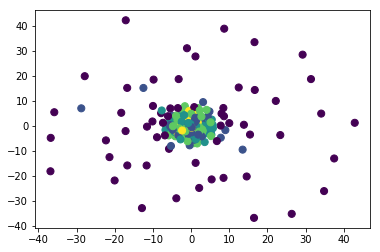

In [7]:
# plot data
scatter(pca_data, labels)

### Part 2: Clustering with DBSCAN

Recall that for DBSCAN, we need to select an Eps and a MinPts. If we choose MinPts to be 4, then Eps can be selected by plotting the distance of every point to its 4th nearest neighbor and finding the "bend" in the graph. 

Q3. Find the optimal Eps for this dataset by plotting the distances of every point to its 4th nearest neighbor.
* Use `sklearn.neighbors.NearestNeighbors` with `n_neighbors=4`. Call `fit` on your data.
* Use the `kneighbors` method to find the distance of each point to its 4th nearest neighbor. Note that `kneighbors` returns two values. The first return value is a matrix of distances from each point to its k nearest neighbors. For example: 

Sklearn considers the distance from the point to itself as the closest neighbor (a distance of 0), then if the point is a distance of 2.5 away from its second nearest neighbor, a distance of 3.7 away from its third nearest neighbor, and a distance of 4.2 away from its fourth nearest neighbor, the row in the distance matrix for this point would look like: `[0, 2.5, 3.7, 4.2]`, indicating that 4.2 is the distance from this point to it's 4th nearest neighbor. 

* Plot the distance of every point to its 4th nearest neighbor. Be sure to sort the distances before you plot them. You can use `plt.plot(distances)` then `plt.show()` to plot them. 
* Use the plot to determine the best Eps for this dataset (just eyeball it).

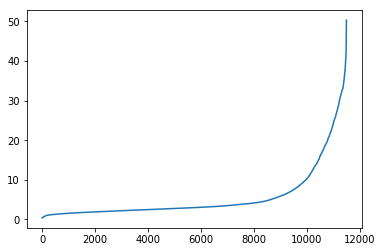

In [8]:
# do nearest neighbor
neigh = NearestNeighbors(n_neighbors=4)
neigh.fit(pca_data) 
# find the distances
distances, indices = neigh.kneighbors(pca_data)
# plot the distances

dist = np.sort(distances[:,1])
plt.plot(dist)
plt.show()
# best Eps seems to be at 4

Q4. 
* Using MinPts=4 and Eps=the distance you determined from Q4, cluster the data using `sklearn.cluster.DBSCAN`. Call `fit_predict` on your data and store the return value (the predicted cluster label for each data point). Note that the returned type is a numpy array. 
* Use the provided `scatter` function (Q2) to plot the resulting clusters. You will need to cast the numpy array of predicted labels to a `Series` in order to pass it in to `scatter`.

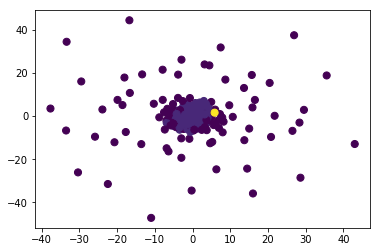

In [10]:
# perform DBSCAN
clustering = DBSCAN(eps=4, min_samples=4).fit_predict(pca_data)
clustering = pd.Series(clustering)
scatter(pca_data, clustering, 300)

### Part 3: Clustering with K-means

Q5. 
* Use `sklearn.cluster.KMeans` to cluster this data using K means. Try values of k from 2 to 5. You will need to call `fit_predict` on your data and store the return value (the predicted cluster label for each data point). Note that the returned type is a numpy array. 
* Use `sklearn.metrics.silhouette_score` to evaluate which is the best number of clusters for this dataset. Note that you will need to cast the numpy array to a Series in order to pass it in to `silhouette_score`.
* Use the provided `scatter` function (Q2) to plot the clustering that resulted in the best shilhouette score.

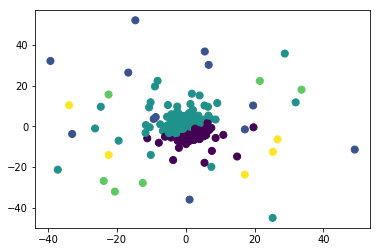

In [12]:
# perform k means
kmeans2 = KMeans(n_clusters=2).fit_predict(pca_data)
kmeans2 = pd.Series(kmeans2)
score2 = silhouette_score(pca_data,kmeans2)

kmeans3 = KMeans(n_clusters=3).fit_predict(pca_data)
kmeans3 = pd.Series(kmeans3)
score3 = silhouette_score(pca_data,kmeans3)

kmeans4 = KMeans(n_clusters=4).fit_predict(pca_data)
kmeans4 = pd.Series(kmeans4)
score4 = silhouette_score(pca_data,kmeans4)

kmeans5 = KMeans(n_clusters=5).fit_predict(pca_data)
kmeans5 = pd.Series(kmeans5)
score5 = silhouette_score(pca_data,kmeans5)

# k=5 had the best score
score5
scatter(pca_data, kmeans5, 300)

Q6. What do you observe about the results of DBSCAN vs the results of K-means? Answer as a comment.

In [50]:
'''
DBSCAN produced more distinct clusters, while K-means clusters produced 5 clusters with weaker clusters.
'''

'\nDBSCAN produced more distinct clusters, while K-means clusters produced 5 clusters with weaker clusters.\n'

### Part 4: Hierarchical Clustering

For hierarchical clustering (Q7 and Q8), you'll work with just a sample of 115 datapoints. The sampling code is provided here for you.

In [13]:
# Do not change the code in this cell
# stratified sampling of the data

def downsample_data(data):
    downData = None
    downLabels = None

    kfold = StratifiedKFold(n_splits = 100, shuffle = True)
    for throwAway_index, subsample_index in kfold.split(data, labels):
        downData = data.iloc[subsample_index]
        downLabels = labels.iloc[subsample_index]
        break

    print(downData.shape)
    return downData

Q7. Use Scipy's hierarchical clustering (`scipy.cluster.hierarchy`) to cluster the data using different linkage methods. **Make sure you are using a down-sampled dataset by passing your dataset into the provided downsample_data() function.**
* Try all of these linkage methods: `single`, `complete`, `average`, `centroid`, `ward`
* Note that the return value of the clustering is a linkage matrix (a cophenetic distance matrix)

* Calculate the CPCC of each linkage method to determine which method worked best. Use `scipy.cluster.hierarchy.cophenet` for this. You'll pass in the linkage matrix and a proximity matrix that contains the actual distances between each point. 

In [14]:
# Make sure to pass your dataset into downsample_data() 
# and use the resulting smaller dataset for hierachical clustering
down_data = downsample_data(pca_data) 

# Pass the down-sampled dataset into pdist to get your proximity matrix for calculating CPCC
proximity_matrix = pdist(down_data)

# try the linkage methods
ward = linkage(down_data, 'ward')
single = linkage(down_data, 'single')
complete = linkage(down_data, 'complete')
average = linkage(down_data, 'average')
centroid = linkage(down_data, 'centroid')

# the average linkage method produced the best CPCC
averageX = cophenet(average)
np.corrcoef(proximity_matrix, averageX)[0,1]

(115, 39)


0.991206088333319

Q8. Using the best linkage method that you found in Q7, plot the dendrogram with `scipy.cluster.hierarchy.dendrogram`. 

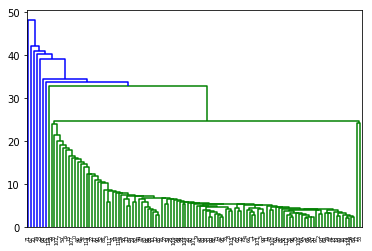

In [15]:
# get dendrogram and plot
dn = dendrogram(average)
plt.show()

### Part 5: Anomaly Detection

In most real life applications the data observations are subject to noise present either in the environment or the sensor apparatus. Anomaly detection (AD) plays a vital role in the preprocessing stage to identify these outliers and optionally remove them from the data set. Anomaly detection algorithms can be broadly classified into 3 classes (see Nicolas Goix's [slides](https://ngoix.github.io/nicolas_goix_osi_presentation.pdf) on anomaly detection):
- Supervised AD (labels available for both normal data and anomalies)
- Semi-supervised AD, also called Novelty Detection (only normal data available to train)
- Unsupervised AD, also called Outlier Detection (no labels are provided)

In this part you'll experiment with 4 datasets and compare 4 different outlier detection (Unsupervised AD) methods.

In [16]:
# loading the datasets
filenames = ['data1.csv', 'data2.csv', 'data3.csv', 'data4.csv']
datasets = [np.loadtxt(fname, delimiter=', ') for fname in filenames]
for fname, data in zip(filenames, datasets):
    print (fname, data.shape)

data1.csv (445, 2)
data2.csv (314, 2)
data3.csv (419, 2)
data4.csv (441, 2)


Q10. Detect the outliers in all 4 datasets using the following algorithms:
- `sklearn.covariance.EllipticEnvelope` - a statistical-based AD method
- `sklearn.ensemble.IsolationForest` - an isolation-based AD method
- `sklearn.neighbors.LocalOutlierFactor` - a density-based AD method
- `sklearn.svm.OneClassSVM` - a model-based AD method

Create scatterplots that show the outliers detected in each dataset with each method. (16 plots in total.)
For example:
![title](scatters.png)

The following plotting function is provided for you. You should pass in a list of `y_pred` values corresponding to all 16 of your plots. In order for this plotting function to work correctly, the order of your list should be: ElipticEnvelope on dataset1, IsolationForest on dataset1, LocalOutlierFactor on dataset1, One-Class SVM on dataset1, ElipticEnvelope on dataset 2, IsolationForest on ds2, LOF on ds2, SVM on ds2, ElipticEnvelope on dataset3, IsolationForest on ds3, LOF on ds3, SVM on ds3, EE on dataset4, IF on ds4, LOF on ds4, SVM on ds4.

In [17]:
# Do not change code in this cell!

def plot_all(y_preds):
    
    print("len(y_preds):", len(y_preds))
    
    names = ['Robust Covariance', 'Isolation Forest', 'Local Outlier Factor', 'One-Class SVM']
    plt.figure(figsize=(len(names) * 2 + 3, 12.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
    plot_num = 1
    
    for i_dataset in range(len(datasets)):
        for j_algorithm in range(len(names)):
            
            plt.subplot(len(datasets), len(names), plot_num)
            if i_dataset == 0:
                plt.title(names[j_algorithm], size=18)

            colors = np.array(['#377eb8', '#ff7f00'])
            plt.scatter(datasets[i_dataset][:, 0], datasets[i_dataset][:, 1], 
                        s=10, color=colors[(y_preds[plot_num-1] + 1) // 2])

            plt.xlim(-7, 7)
            plt.ylim(-7, 7)
            plt.xticks(())
            plt.yticks(())
            
            plot_num += 1

    plt.show()

Directions:
* Use a `contamination` (or `nu` for `OneClassSVM`) of 0.25.
* For the `OneClassSVM` use `rbf` kernel.
* NOTE: To preform anomaly detection in an unsupervised way, you will pass the same dataset into `fit` and `predict.`

Some code is provided here to get you started.

len(y_preds): 16


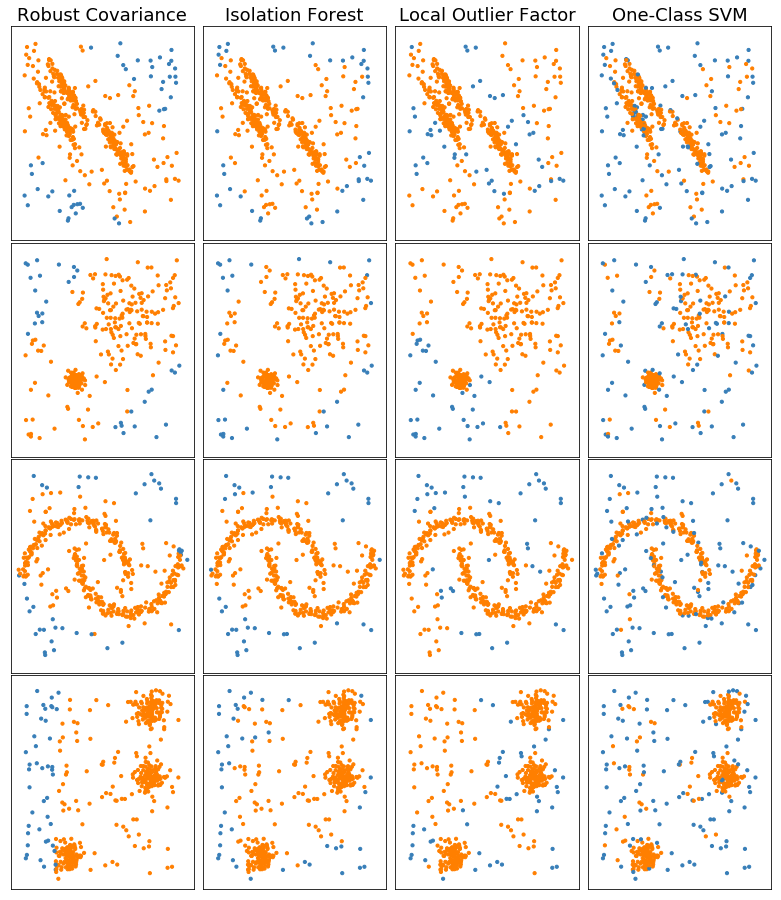

In [26]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


outliers_fraction = 0.25

#this will be your list of 16 plots
y_pred_list = list()


for i_dataset in range(len(datasets)):
    #apply EllipticEnvelope AD
    EE = EllipticEnvelope().fit(datasets[i_dataset]).predict(datasets[i_dataset])
    #append resulting y_pred to y_pred_list
    y_pred_list.append(EE)
    
    #apply IsolationForest AD
    IF = IsolationForest().fit(datasets[i_dataset]).predict(datasets[i_dataset])
    #append resulting y_pred to y_pred_list
    y_pred_list.append(IF)
    
    #apply LocalOutlierFactor AD
    LOF = LocalOutlierFactor().fit_predict(datasets[i_dataset])
    #append resulting y_pred to y_pred_list
    y_pred_list.append(LOF)

    #apply OneClassSVM AD
    clf = OneClassSVM(nu=0.25, kernel="rbf")
    OCS = clf.fit(datasets[i_dataset]).predict(datasets[i_dataset])
    #append resulting y_pred to y_pred_list
    y_pred_list.append(OCS)

 

plot_all(y_pred_list)